In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvnn import layers 

2023-09-04 11:57:49.937267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 11:57:51.956538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# data_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'
# file_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'

In [3]:
# file_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'
# data_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [4]:
file_loc = 'EOS4_FRS1_SLC/scene_HH/'
data_loc = 'EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [5]:
mask = np.load(data_loc+'mask.npy')

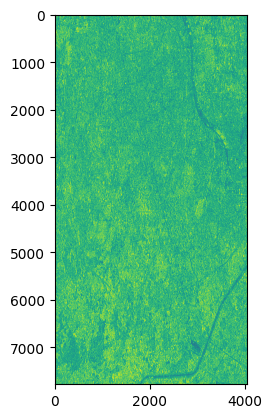

In [6]:
plt.imshow(mask)

In [7]:
inputs = np.load(file_loc+'input.npy')

In [8]:
import patchify as pat

In [9]:
img_dim  = 32

In [10]:
patches_inp = pat.patchify(inputs, (img_dim, img_dim), step=img_dim)
patches_mask = pat.patchify(mask, (img_dim,img_dim), step=img_dim)

In [11]:
patches_mask.shape[0]*patches_mask.shape[1]

30618

In [12]:
patches_inp.shape

(243, 126, 32, 32)

In [13]:
input_img = np.reshape(patches_inp, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])
mask_img = np.reshape(patches_mask, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])

In [14]:
input_img = np.expand_dims(input_img, -1)
mask_img = np.expand_dims(mask_img, -1)

In [15]:
from keras.utils import to_categorical
classes = np.unique(mask_img[0]).astype(int)
mask_cat = to_categorical(mask_img)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_img, mask_cat, test_size = 0.25, random_state = 4)

In [17]:
mask_cat[0].shape

(32, 32, 4)

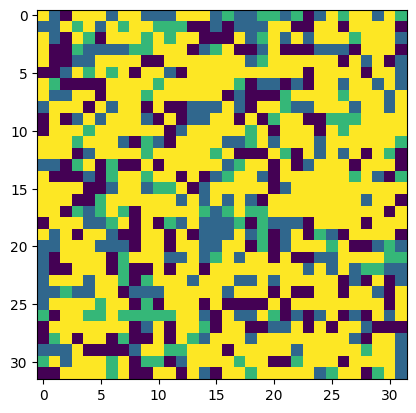

In [18]:
plt.imshow(mask_img[25])

In [19]:
X_train.shape[1:]

(32, 32, 1)

In [20]:
input_shape = (X_train.shape[1:])
# input_shape = np.array(input_shape).reshape(-1, 256, 256, 1)
dtype  = tf.complex64

In [21]:
from tensorflow.keras.layers import Activation
from cvnn.activations import cart_softmax, cart_relu, cart_leaky_relu

In [22]:
def _downsample_cvnn(inputs, units, dtype=dtype):
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype = dtype)(inputs)
    # c1 = layers.ComplexDropout(0.3)(c1)
    # c1 = layers.ComplexBatchNormalization(dtype=dtype)(c1)
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype= dtype)(c1)
    # c1 = layers.ComplexDropout(0.3)(c1)
    c1 = layers.ComplexBatchNormalization(dtype=dtype)(c1)  
    c1 = Activation(cart_leaky_relu)(c1)
    p1 = layers.ComplexMaxPooling2D((2,2), dtype=dtype)(c1)
    p1 = layers.ComplexDropout(rate=0.3, dtype=dtype)(p1)
    return (c1, p1) 

In [23]:
# def _downsample_cvnn(inputs, units):
#     c0 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(inputs)
#     c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(c0)
#     c2 = layers.ComplexMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)
#     return c0, c1, c2

In [24]:
def _upsample_cvnn(in1, in2, units, dtype = dtype):
    # print(in1.shape)
    t01 = layers.ComplexConv2DTranspose(units, (2, 2), strides=(2,2), activation='cart_leaky_relu', dtype=dtype, padding='same')(in1)
    # t01 = layers.ComplexDropout(0.3)(t01)
    # crop01 = tf.keras.layers.Cropping2D(cropping=(crop, crop))(in2)
    # t01 = layers.ComplexUpSampling2D(size=4, interpolation='bilinear', data_format='channels_first')(t01)
    # print(t01.shape)
    concat01 = tf.keras.layers.concatenate([t01, in2], axis=-1)
    concat01 = layers.ComplexBatchNormalization(dtype=dtype)(concat01)  
    concat01 = Activation(cart_leaky_relu)(concat01)
    out1 = layers.ComplexConv2D(units, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding='same')(concat01)
    out1 = layers.ComplexDropout(rate=0.3, dtype=dtype)(out1)
    out2 = layers.ComplexConv2D(units, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding ='same')(out1)
    out2 = layers.ComplexDropout(rate = 0.3, dtype=dtype)(out2)
    return out1, out2

In [25]:
input_shape

(32, 32, 1)

In [26]:
from cvnn import losses
from tensorflow.keras.optimizers import Adam

In [27]:
# losses.ComplexWeightedAverageCrossEntropyIgnoreUnlabeled

In [28]:
from cvnn.metrics import ComplexCategoricalAccuracy, ComplexAverageAccuracy, ComplexPrecision, ComplexRecall

/home/saumya/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [29]:
def cvnn_unet(dtype = tf.complex64):
    tf.random.set_seed(1)
    inputs = layers.complex_input(shape=input_shape, dtype=dtype)
    # c91, c92, c93 = _downsample_cvnn(inputs, 32, dtype)
    c0, c1 = _downsample_cvnn(inputs,32)
    c3, c4 = _downsample_cvnn(c1, 64)
    c6, c7 = _downsample_cvnn(c4, 128)
    # c9, c10 = _downsample_cvnn(c7, 256)
    # print(c9.shape)
    # print(c10.shape)

    # c12 = layers.ComplexConv2D(1024, activation='cart_leaky_relu', kernel_size=3)(c10)
    # c13 = layers.ComplexConv2D(1024, activation='cart_leaky_relu', kernel_size=3, padding='valid')(c12)

    # c14, c15 = _upsample_cvnn(c10, c9, 256, dtype)
    c16, c17 = _upsample_cvnn(c7, c6, 128, dtype)
    c18, c19 = _upsample_cvnn(c17, c3, 64, dtype)
    c20, c21 = _upsample_cvnn(c19, c0, 32, dtype)

    outputs = layers.ComplexConv2D(4, kernel_size=1, activation = 'softmax_real_with_avg', dtype=dtype)(c21)
    # outputs = layers.ComplexConv2D(1, kernel_size=1)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net-cvnn")
    model.compile(loss=losses.ComplexAverageCrossEntropyIgnoreUnlabeled(), optimizer=Adam(lr = 1e-4), metrics=[ComplexCategoricalAccuracy(name='accuracy'),
                           ComplexAverageAccuracy(name='average_accuracy'),
                           ComplexPrecision(name='precision'),
                           ComplexRecall(name='recall')
                           ])
    return model


In [30]:
k = cvnn_unet()
print(k.summary())

2023-09-04 11:58:12.428204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30543 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-09-04 11:58:12.437161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14314 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Model: "u-net-cvnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (ComplexInput)      [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 complex_conv2d (ComplexCon  (None, 32, 32, 32)           640       ['input_1[0][0]']             
 v2D)                                                                                             
                                                                                                  
 complex_conv2d_1 (ComplexC  (None, 32, 32, 32)           18496     ['complex_conv2d[0][0]']      
 onv2D)                                                                                           
                                                                                         

In [31]:
# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=input_shape + (3,)))
# model.add(complex_layers.ComplexConv2D(32, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(64, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(128, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(256, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexFlatten())

In [32]:
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True
    # sess = tf.Session(config=config)

In [33]:
history = k.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100


2023-09-04 11:59:03.972310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-04 11:59:08.144432: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x28989540
2023-09-04 11:59:10.466835: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0081b5be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-04 11:59:10.466950: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-09-04 11:59:10.466978: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-PCIE-16GB, Compute Capability 7.0
2023-09-04 11:59:10.510416: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-04 11:59:10.510699: I tensorflow/compiler/mlir/tensorflow/utils/dump_ml

575/575 [==============================] - 1451s 2s/step - loss: 1.1164 - accuracy: 0.5473 - average_accuracy: 0.2698 - precision: 0.6373 - recall: 0.3658 - val_loss: 1.0764 - val_accuracy: 0.5557 - val_average_accuracy: 0.2769 - val_precision: 0.6404 - val_recall: 0.4304
Epoch 2/100
575/575 [==============================] - 1393s 2s/step - loss: 1.0824 - accuracy: 0.5547 - average_accuracy: 0.2907 - precision: 0.6506 - recall: 0.3997 - val_loss: 1.0693 - val_accuracy: 0.5581 - val_average_accuracy: 0.2933 - val_precision: 0.6481 - val_recall: 0.4207
Epoch 3/100
575/575 [==============================] - 1343s 2s/step - loss: 1.0776 - accuracy: 0.5557 - average_accuracy: 0.2909 - precision: 0.6513 - recall: 0.4048 - val_loss: 1.0758 - val_accuracy: 0.5578 - val_average_accuracy: 0.2823 - val_precision: 0.6349 - val_recall: 0.4406
Epoch 4/100
575/575 [==============================] - 1393s 2s/step - loss: 1.0755 - accuracy: 0.5562 - average_accuracy: 0.2897 - precision: 0.6515 - recal

In [34]:
X_train.shape

(22963, 32, 32, 1)

In [35]:
y_train.shape

(22963, 32, 32, 4)

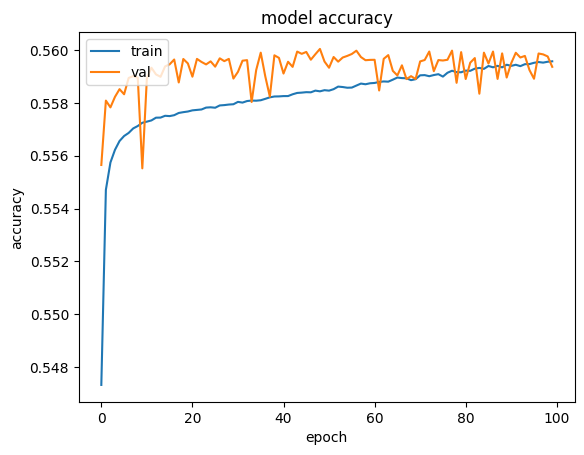

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

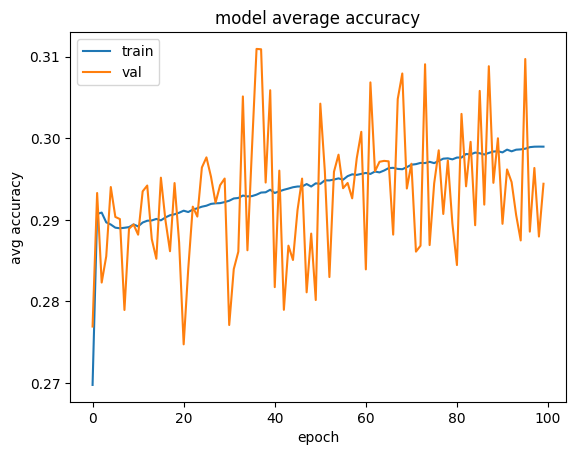

In [37]:
plt.plot(history.history['average_accuracy'])
plt.plot(history.history['val_average_accuracy'])
plt.title('model average accuracy')
plt.ylabel('avg accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

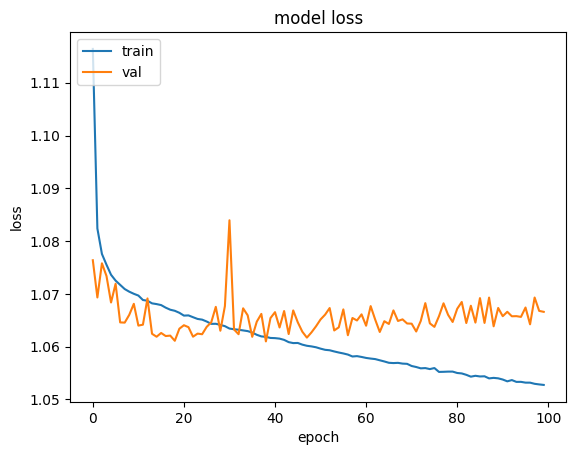

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


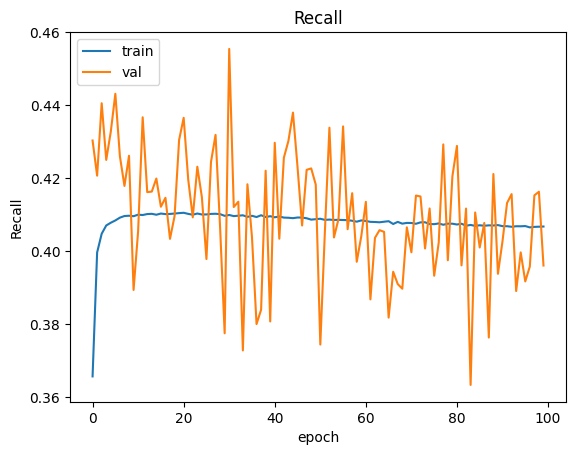

In [40]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()